<a href="https://colab.research.google.com/github/black0017/MedicalZooPytorch/blob/beta/Plot_3D_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
from typing import List, Tuple, Optional, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.exposure import rescale_intensity

def to_rgb(array: np.ndarray) -> np.ndarray:
    if array.shape[-1] == 3:  # assume it's already RGB
        return array
    array = array.astype(float)
    array -= array.min()
    array /= array.max()
    array *= 255
    array = array.astype(np.uint8)
    rgb = np.stack(3 * [array], axis=-1)
    return rgb


def turn(array_2d: np.ndarray) -> np.ndarray:
    return np.flipud(np.rot90(array_2d))


def rescale_array(
        array: np.ndarray,
        cutoff: Tuple[float, float] = (2, 98),
        ) -> np.ndarray:
    percentiles = tuple(np.percentile(array, cutoff))
    array = rescale_intensity(array, in_range=percentiles)
    return array


def add_intersections(
        slices: Tuple[np.ndarray, np.ndarray, np.ndarray],
        i: int,
        j: int,
        k: int,
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Colors from 3D Slicer
    """
    sag, cor, axi = slices
    red = 255, 131, 114
    green = 143, 229, 97
    yellow = 255, 237, 135
    sag[j, :] = green
    sag[:, k] = red
    cor[i, :] = yellow
    cor[:, k] = red
    axi[i, :] = yellow
    axi[:, j] = green
    return sag, cor, axi


def plot_volume(
        array: np.ndarray,
        enhance: bool = True,
        title: Optional[str] = None,
        idx_sag: Optional[int] = None,
        idx_cor: Optional[int] = None,
        idx_axi: Optional[int] = None,
        return_figure: bool = False,
        intersections: bool = True,
        ) -> Optional[plt.Figure]:
    """
    Expects an isotropic-spacing volume in RAS orientation
    """
    if array.ndim > 5:
        array = array[0]
    if array.ndim == 5:
        array = array[..., 0, 0]  # 5D to 3D
    if enhance:
        array = rescale_array(array)
    si, sj, sk = array.shape[:3]
    i = idx_sag if idx_sag is not None else si // 2
    j = idx_cor if idx_cor is not None else sj // 2
    k = idx_axi if idx_axi is not None else sk // 2
    slices = [
        array[i, ...],
        array[:, j, ...],
        array[:, :, k, ...],
    ]

    if intersections:
        slices = [to_rgb(s) for s in slices]
        slices = add_intersections(tuple(slices), i, j, k)
    cmap = 'gray' if array.ndim == 3 else None
    labels = 'AS', 'RS', 'RA'
    titles = 'Sagittal', 'Coronal', 'Axial'

    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[256 / 160, 1, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    axes = ax1, ax2, ax3
    for (slice_, axis, label, stitle) in zip(slices, axes, labels, titles):
        axis.imshow(turn(slice_), cmap=cmap)
        axis.grid(False)
        axis.invert_xaxis()
        axis.invert_yaxis()
        x, y = label
        axis.set_xlabel(x)
        axis.set_ylabel(y)
        axis.set_title(stitle)
        axis.set_aspect('equal')
    if title is not None:
        plt.gcf().suptitle(title)
    plt.tight_layout()
    if return_figure:
        return fig

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 42.5MB 99kB/s 
If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



Extracting /root/.cache/torchio/mni_colin27_1998_nifti/mni_colin27_1998_nifti.zip to /root/.cache/torchio/mni_colin27_1998_nifti



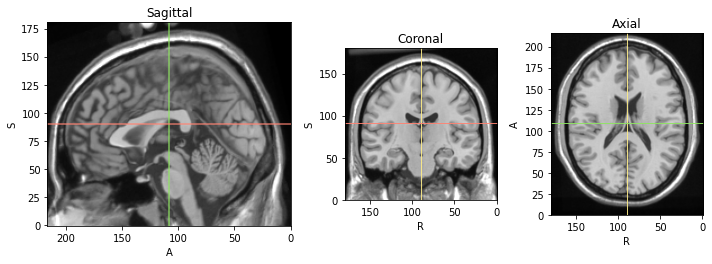

In [2]:
!pip install -q torchio
import torchio as tio
array = tio.datasets.Colin27().t1.numpy()[0]
plot_volume(array)